<a href="https://colab.research.google.com/github/Nsharma96/Knowledge-graph-embeddings/blob/master/Graph_ampli_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 1.x
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14
!pip install ampligraph==1.3.2

In [1]:
import sys,os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
bpath = '/content/drive/My Drive/Stock Data' #datasetdir
sys.path.insert(0,bpath)
os.chdir(bpath)

In [ ]:
import ampligraph
import pandas as pd
import numpy as np
import tensorflow as tf
ampligraph.__version__

In [4]:
rem = pd.read_csv('tripletsV2.csv')
display(rem.head())
rem['id'] = rem['id'].apply(lambda x: str(x))
x = rem[['name','rel','prop']]
x = x.values
for i in x:
  if len(i)==0:
    print("lenth 0")
x[:5, ]


,id,name,rel,prop
0,24831275,modular office furniture,COLOR,white
1,24831275,modular office furniture,HAS_UNIT,square feet
2,24831275,modular office furniture,HAS_PRICE,600
3,31743796,office furniture,MATERIAL,plywood
4,31743796,office furniture,HAS_UNIT,piece


array([['modular office furniture', 'COLOR', 'white'],
       ['modular office furniture', 'HAS_UNIT', 'square feet'],
       ['modular office furniture', 'HAS_PRICE', '600'],
       ['office furniture', 'MATERIAL', 'plywood'],
       ['office furniture', 'HAS_UNIT', 'piece']], dtype=object)

In [5]:
entities = np.unique(np.concatenate([x[:, 0], x[:, 2]]))
entities

array(['(d) 900 mm x (h) 750 mm', '(l) 1800mm x (d) 900mm x (h) 750mm',
       '(l)1200mm x (d)600mm x (h)750mm', ..., 'zsi-04 boss office chair',
       'zsi-10 executive chair', 'zsi-70 staff chair'], dtype=object)

In [6]:
relations = np.unique(x[:, 1])
relations

array(['ADJUSTABLE SEAT HEIGHT', 'AGE GROUP', 'APPEARANCE', 'APPLICATION',
       'ARM REST', 'ARM STYLE', 'ARM TYPE', 'ARMREST', 'BACK HEIGHT',
       'BACK TYPE', 'BENCH SIZE', 'BENCH TYPE', 'BODY MATERIAL', 'BRAND',
       'BRAND NAME', 'BRAND PREFERENCE', 'BUILT TYPE', 'CABINET TYPE',
       'CHAIR TYPE', 'CHIPSET TYPE', 'COLOR', 'COLOUR',
       'COMPANY WORK PROFILE', 'DESIGN', 'DESIGN TYPE', 'DIMENSION',
       'DISPATCH TIME', 'DOOR TYPE', 'EXCHANGE ACCEPTED', 'FEATURES',
       'FRAME TYPE', 'HAS_PRICE', 'HAS_UNIT', 'HEIGHT', 'I ALSO PROVIDE',
       'IDEAL FOR', 'INSTITUTIONAL CHAIR', 'IS IT ROTATABLE', 'ITEM CODE',
       'KITCHEN SHAPE', 'LAYOUT TYPE', 'LEG MATERIAL', 'LOCK TYPE',
       'MATERIAL', 'MATERIAL FINISH', 'MODEL', 'MODEL NAME/NUMBER',
       'MODEL NO', 'MODEL NUMBER', 'MODEL NUMBER/NAME',
       'MODULAR KITCHEN COMPONENTS', 'NO OF LEGS', 'NO OF LOCKERS',
       'NO OF SEATER', 'NO OF WHEELS', 'NO. OF DOORS', 'NO. OF DRAWERS',
       'NO. OF SHELVES', 'NUMBER 

In [7]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train_valid, X_test = train_test_split_no_unseen(x, test_size=3000)
X_train, X_valid = train_test_split_no_unseen(X_train_valid, test_size=3000)
# X_train, X_test = train_test_split_no_unseen(x, test_size=3000)

In [8]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)
print('Validation set size: ', X_valid.shape)

Train set size:  (11241, 3)
Test set size:  (3000, 3)
Validation set size:  (3000, 3)


In [9]:

from ampligraph.latent_features import ComplEx

In [10]:
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=300, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

In [11]:
positives_filter = x

In [12]:
tf.logging.set_verbosity(tf.logging.ERROR)
# model.fit(X_train, ,early_stopping = True)
model.fit(X_train, early_stopping = True,early_stopping_params = \
                  {
                      'x_valid': X_valid,       # validation set
                      'criteria':'hits10',         # Uses hits10 criteria for early stopping
                      'burn_in': 100,              # early stopping kicks in after 100 epochs
                      'check_interval':20,         # validates every 20th epoch
                      'stop_interval':5,           # stops if 5 successive validation checks are bad.
                      'x_filter': positives_filter,          # Use filter for filtering out positives 
                      'corruption_entities':'all', # corrupt using all entities
                      'corrupt_side':'s+o'         # corrupt subject and object (but not at once)
                  },
          )

Average Loss:   0.032780 — Best validation (hits10): 0.139000: 100%|██████████| 300/300 [04:33<00:00,  1.10epoch/s]


In [13]:
from ampligraph.latent_features import save_model, restore_model
# save_model(model, './best_model.pkl')
model = restore_model('./best_model.pkl')
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


In [14]:
print(X_train)
print(np.__version__)

[['modular office furniture' 'HAS_UNIT' 'square feet']
 ['office furniture' 'MATERIAL' 'plywood']
 ['office furniture' 'HAS_UNIT' 'piece']
 ...
 ['stainless steel school desk' 'MATERIAL' 'stainless steel']
 ['stainless steel school desk' 'HAS_PRICE' '1200']
 ['stainless steel school desk' 'HAS_UNIT' 'unit']]
1.18.5


In [15]:
from ampligraph.evaluation import evaluate_performance
# X_test = 
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 2854/2854 [00:10<00:00, 260.94it/s]


In [16]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.46
Hits@10: 0.55
Hits@3: 0.48
Hits@1: 0.42


In [ ]:
from scipy.special import expit
X_unseen = X_test[:1000]
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))
ranks_unseen = evaluate_performance(
    X_unseen, 
    model=model, 
    filter_triples=unseen_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True,
    filter_unseen=True
)
# scores = model.predict(X_unseen)
# probs = expit(scores)
# print(probs)

output = pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen,)) , 
             columns=['statement', 'rank',]).sort_values("rank")

In [78]:
print(output['rank'].value_counts())

1       279
2        39
3        14
5        11
4         9
       ... 
6583      1
624       1
8571      1
633       1
2447      1
Name: rank, Length: 449, dtype: int64


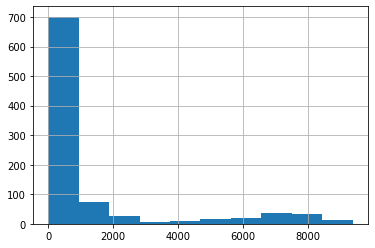

In [83]:
# output['rank'].hist()

In [ ]:
**************************************end code********************************************

In [73]:
data = pd.read_csv('tripletsV2.csv')
print(data.shape)
data.drop(data[data['name'] == 'no pc_item'].index, inplace=True)
data.drop(data[data['prop'] == 'no price'].index, inplace=True)
print(data.shape)
len(data['name'])

(17241, 4)
(16711, 4)


16711

In [74]:
price_bucket = pd.read_csv('price_bucket.csv')

#Create dictionary for price buckets for mapping.
p_range_map  = dict()
count = 0
for i in range(len(price_bucket['lower'])):
  p_range_map[count] = [price_bucket['lower'].iloc[i],price_bucket['upper'].iloc[i]]
  count+=1

In [ ]:
model.get_embeddings()

In [ ]:
import itertools
pcItem = data['name'].unique()
print(type(pcItem))
display(pcItem)
pcItem_embeddings = dict(zip(pcItem,model.get_embeddings(pcItem)))

ke = []
val = []
for k,v in pcItem_embeddings.items():
  ke.append(k)
  val.append(v)
embed_df = pd.DataFrame({'name':ke,'embed':val})


price_df = pd.read_csv('item_price.csv')
price_df.drop(price_df[price_df['item_name'] == 'no pc_item'].index, inplace=True)
price_df.drop(price_df[price_df['price'] == 'no price'].index, inplace=True)
price_df['embed'] = price_df['item_name'].apply(lambda x: pcItem_embeddings[x])

price_df1 = pd.DataFrame(price_df.embed.values.tolist()).add_prefix('embed_')
price_df1['price'] = price_df['price']
price_df1['name'] = price_df['item_name']
price_df = price_df1 
# print(price_df.loc[price_df['name'] == 'revolving computer chair'])

price_df.dropna(inplace = True)
#Build target variable
l = []
for i in range(len(price_df['price'])):
    for k,v in p_range_map.items():
      if(price_df['price'].iloc[i]>=v[0] and price_df['price'].iloc[i]<=v[1]):
        l.append(k)
        break
price_df['target'] = l
# price_df['target'] = (price_df.price>4000).astype(int)


print(price_df.head())
print(price_df.describe())
print(embed_df.head())
print(embed_df.describe())
# print(dict(itertools.islice(pcItem_embeddings.items(), 2)))

In [ ]:
import matplotlib.pyplot as plt
price_df.drop(price_df[price_df['price'] == 0].index, inplace=True)
fig = plt.figure(figsize = (30,10))
ax = fig.gca()
price_df.to_csv('training.csv')
print(price_df['target'].hist(bins=59,ax=ax))
print(price_df[price_df['target']>=40])

In [ ]:
train_dataset = price_df.sample(frac=0.8,random_state=0)
test_dataset = price_df.drop(train_dataset.index)
train_dataset.pop('price')
test_dataset.pop('price')

In [ ]:
clf_X_train = train_dataset
clf_X_test = test_dataset
y_train = train_dataset.pop('target')
y_test = test_dataset.pop('target')

In [ ]:
clf_X_train.shape, clf_X_test.shape

In [ ]:
from imblearn.over_sampling import RandomOverSampler,SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
pipeline = Pipeline(steps=[('r', ros), ('u', rus)])
X_resampled, y_resampled = pipeline.fit_resample(clf_X_train.iloc[:,:-1], y_train)

In [ ]:
temp = pd.DataFrame(X_resampled)
temp['label'] = y_resampled
temp['label'].hist(bins=49)

In [ ]:
X_resampled.shape, clf_X_test.shape

In [ ]:
print(X_resampled)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# rf = rf.fit(clf_X_train.iloc[:,:-1],y_train)
rf = rf.fit(X_resampled,y_resampled)
print('rfc trained')

from sklearn.linear_model import LogisticRegression
# lrcv = LogisticRegression(random_state=0,verbose=2,max_iter = 500).fit(clf_X_train.iloc[:,:-1], y_train)
lrcv = LogisticRegression(random_state=0,verbose=2,max_iter = 500).fit(X_resampled, y_resampled)

print('lrcv trained')

from xgboost import XGBClassifier
clf_model = XGBClassifier()
# clf_model.fit(clf_X_train.iloc[:,:-1], y_train)
clf_model.fit(X_resampled,y_resampled)
print('Xgboost trained')

from sklearn.ensemble import RandomForestRegressor
# regr = RandomForestRegressor(random_state=0,verbose = 1,criterion = 'mae',n_estimators=20)
# # regr.fit(clf_X_train.iloc[:,:-1], y_train)
# regr.fit(X_resampled,y_resampled)
# print('reger trained')

import xgboost as xgb
# data_dmatrix = xgb.DMatrix(data=clf_X_train.iloc[:,:-1],label=y_train)
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', learning_rate = 0.1, n_estimators = 300,verbose = 1,)
# xg_reg.fit(clf_X_train,y_train)

In [ ]:
# ypred_regr = np.round(regr.predict(clf_X_test.iloc[:,:-1]))
# ypred_xg_reg = np.round(xg_reg.predict(clf_X_test.iloc[:,:-1]))

In [ ]:
from sklearn import metrics
# metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))
print(metrics.accuracy_score(y_test, rf.predict(clf_X_test.iloc[:,:-1])))
print(metrics.accuracy_score(y_test, lrcv.predict(clf_X_test.iloc[:,:-1])))
print(metrics.accuracy_score(y_test, ypred_regr))
# print(metrics.accuracy_score(y_test, ypred_xg_reg))


# print(metrics.accuracy_score(y_test, clf_model.predict(clf_X_test.iloc[:,:-1])))

In [ ]:
 lrcv.predict(clf_X_test.iloc[:,:-1])

In [ ]:
display(y_test.values)